# Real-Time Corona Face Mask Detection

In [1]:
import os
import random
import cv2 # OpenCV
import matplotlib.pyplot as plt
import xmltodict # PyPI library that treats XMLs as JSON files (containing key values pairs)
import torch # PyTorch
import torchvision # PyTorch library containing useful attributes and functionalities
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
os.chdir('/')
os.chdir('C:/IIT-K Project/')
os.getcwd()

'C:\\IIT-K Project'

URL of primary dataset used to train the model: https://makeml.app/datasets/mask

In [3]:
def ImageNames():
    '''
    function to get the names of images in the dataset
    '''
    imgs = []
    for dname, _, fname in os.walk('/IIT-K Project/Dataset/images/'):
        for f in fname:
            fpath = os.path.join(dname,f)
            ext = fpath[len(fpath)-4:]
            if ext != '.xml':
                imgs.append(f)
    return imgs

In [4]:
def Path(img):
    '''
    function to get the path of the images and their labels in the dataset
    '''
    o = '/IIT-K Project/Dataset/'
    i = o + 'images/' + img
    if img[-4:] == 'jpeg':
        lbl = img[:-5] + '.xml'
    else: # 'jpg' or 'png'
        lbl = img[:-4] + '.xml'
    l = o + 'annotations/' + lbl
    return i, l

In [5]:
def ParseXML(l):
    '''
    function to convert the labels of XML files to dictionary format and return the classes of dataset along with bounding boxes
    '''
    x = xmltodict.parse(open(l,'rb'))
    items = x['annotation']['object']
    # when image has only one bounding box
    if not isinstance(items,list):
        items = [items]
    res = []
    for i in items:
        n = i['name']
        bb = [(int(i['bndbox']['xmin']), int(i['bndbox']['ymin'])), (int(i['bndbox']['xmax']), int(i['bndbox']['ymax']))]
        res.append((n,bb))
    s = [int(x['annotation']['size']['width']), int(x['annotation']['size']['height'])]
    return res, s  # res contains classes & its bounding box's x,y coords; s contains width & height of bounding box

In [6]:
def Visualize(imgs, bb=True):
    '''
    function to visualize the images in the dataset along with appropriate bounding boxes according to their classes
    '''
    i, l = Path(imgs)
    img = cv2.imread(i)  # reading the image using OpenCV's imread function
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # converting image to RGB format as OpenCV reads image in BGR format
    if bb:  # bb (bounding box) is set as true in function parameter
        lbls, s = ParseXML(l)
        t = int(sum(s)/500)
        for lbl in lbls:
            n, bb = lbl # lbl has the classes and bound box's x,y coords of result as defined by the above fucntion
            if n == 'without_mask' or n == 'bad' : # if mask is not worn, bounding box of red color is drawn
                cv2.rectangle(img, bb[0], bb[1], (255, 0, 0), t)
            elif n == 'with_mask' or n == 'good':  # if mask is worn correctly, bounding box of green color is drawn
                cv2.rectangle(img, bb[0], bb[1], (0, 255, 0), t)
            elif n == 'mask_weared_incorrect' or n == 'none': # if mask is worn incorrectly, bounding box of blue color is drawn
                cv2.rectangle(img, bb[0], bb[1], (0, 0, 255), t)
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,2)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [7]:
imgs = ImageNames() # getting the image names

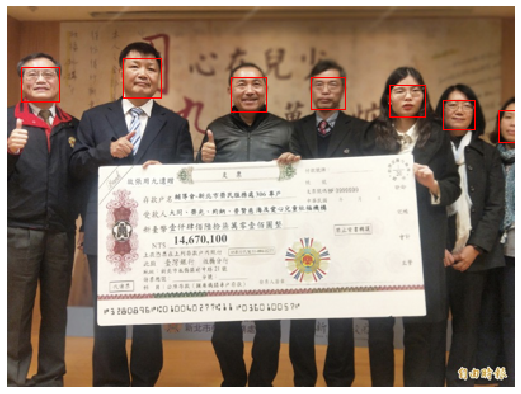

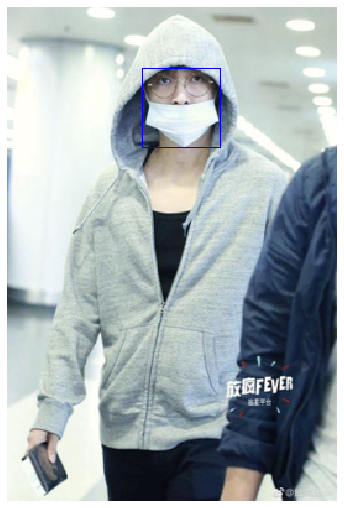

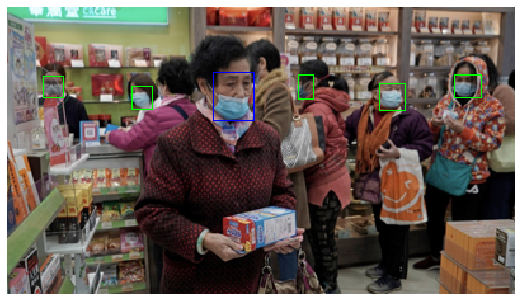

In [8]:
# Testing the bounding boxes on a few randomly selected images in the dataaset
r = random.sample(range(0,len(imgs)),3)
for i in r:
    Visualize(imgs[i])

In [9]:
def CropImage(imgs):
    '''
    function to crop the part of image inside bounding box, and that cropped part will be
    fed as input in a pre-trained neural network ResNet-50, to detect the presence of the mask
    '''
    i, l = Path(imgs)
    # image pre-processing
    img = cv2.imread(i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # getting the labels and bounding boxes' coords and size
    lbls, s = ParseXML(l)
    cropped_img_lbls = []
    for lbl in lbls:
        # from labels we extract the label names and annotation parameters
        n, bb = lbl
        # cropping out the part of image inside bounding box
        cropped_img = img[bb[0][1]:bb[1][1], bb[0][0]:bb[1][0]]
        lbl_num = 0
        # as label contains categorical variables, they are assigned numeric categories
        if n == "with_mask":
            lbl_num = 1
        elif n == "without_mask":
            lbl_num = 2
        elif n == "mask_weared_incorrect" or n == "none":
            lbl_num = 3
        # getting the cropped image and label
        cropped_img_lbl = [cropped_img, lbl_num]
        # creating the list of all cropped images exracted from the input images and its label numbers
        cropped_img_lbls.append(cropped_img_lbl)
    return cropped_img_lbls

In [10]:
# Creating train directory with separate folders belonging to separate classes and also the model directory to save the models

trn = 'train/'
l1 = trn + "1/"
l2 = trn + "2/"
l3 = trn + "3/"
mdl = "model/"

os.mkdir(trn)
os.mkdir(l1)
os.mkdir(l2)
os.mkdir(l3)
os.mkdir(mdl)

In [11]:
lbl1 = 0
lbl2 = 0
lbl3 = 0
for i in imgs:
    cropped_img_lbls = CropImage(i)
    # iterating through the cropped images and their target labels list
    for l in cropped_img_lbls:
        # extracting the images and labels from the list
        img = l[0]
        lbl = l[1]
        # renaming the images with their index numbers along with appending their directory names
        if lbl == 1:
            cropped_img = str(lbl1) + ".png"
            cv2.imwrite(l1 + cropped_img, img)
            lbl1 += 1
        elif lbl == 2:
            cropped_img = str(lbl2) + ".png"
            cv2.imwrite(l2 + cropped_img, img)
            lbl2 += 1
        elif lbl == 3:
            cropped_img = str(lbl3) + ".png"
            cv2.imwrite(l3 + cropped_img, img)
            lbl3 += 1

In [12]:
# Making list of images according to their respective classes
lbl_1 = [f for f in os.listdir(l1) if os.path.isfile(os.path.join(l1, f))]  
lbl_2 = [f for f in os.listdir(l2) if os.path.isfile(os.path.join(l2, f))]
lbl_3 = [f for f in os.listdir(l3) if os.path.isfile(os.path.join(l3, f))]
print("Total no. of images = " + str(len(lbl_1)+len(lbl_2)+len(lbl_3)) + "\n")
print("No. of images labeled 1 = " + str(len(lbl_1)))
print("No. of images labeled 2 = " + str(len(lbl_2)))
print("No. of images labeled 3 = " + str(len(lbl_3)))

Total no. of images = 4198

No. of images labeled 1 = 3232
No. of images labeled 2 = 717
No. of images labeled 3 = 249


In [13]:
# Using GPU for training if available else using CPU to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
# Loading the pre-trained ResNet-50 model for image classification on cropped images
model = models.resnet50(pretrained=True)

In [15]:
for layer, param in model.named_parameters():
    print(layer)
    if 'layer4' not in layer:
        # setting requires grad = False, as we do not want to backpropagate and change the weights and gradients,
        # we will freeze this layer for feature extraction and connect it to our fully connected trainable layers
        param.requires_grad = False 
# Adding our fully connected layer to the pre-trained ResNet-50 block
model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                               torch.nn.ReLU(),
                               torch.nn.Dropout(0.2),
                               torch.nn.Linear(512, 3),
                               torch.nn.LogSoftmax(dim=1))
print(model)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [16]:
# Creating a pipeline for series of tranformations needed to apply to the data
train_transforms = transforms.Compose([
    # resizing the images to 224*224 size arrays
    transforms.Resize((224,224)),
    # converting to PyTorch compatible tensor from ndarray type
    transforms.ToTensor(),
    # normalizing and scaling the image between [0,1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [17]:
# Getting the data from the directory and applying the transformations defined above
data = datasets.ImageFolder(trn,transform=train_transforms)

# Dividing the dataset into train, validation and test data
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = len(data)-train_size-val_size

# Randomly splitting the data for no imbalance of class, and the model performs robustly when trained on random shuffle
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])
print('Train set size: ', len(train_data))
print('Validation set size: ', len(val_data))
print('Test set size: ', len(test_data))

Train set size:  3358
Validation set size:  419
Test set size:  421


In [18]:
batch_size = 64 # increasing to 128 might result in better accuracy and lesser loss, but couldn't because of hardware limitation
learning_rate = 0.001

# Loading the train data
train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Loading the validation data
val = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
# Loading the test data
test = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Using cross-entropy loss and adam optimizer (an upgrade to stochastic gradient descent with momentum capabilities)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
epochs = 20 # choosing based on earlier training results, model stops learning with further epochs

train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Training the model
for epoch in range(1,epochs+1):
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    for x, y in train:
        x, y = x.cuda(), y.cuda()
        # setting zero_grad, as in PyTorch, optimizer keeps accumulating gradients during each backpropagation
        optimizer.zero_grad()
        # forward pass
        result = model(x)
        # calculating the loss
        loss = criterion(result, y)
        # adding the training loss for better tracking of loss minimization process
        epoch_train_loss += loss.item()
        _, maximum_train = torch.max(result.data,1)
        total_train += y.size(0)
        # summing all the correct predictions by matching with the true lables for calculating accuracy
        correct_train += (maximum_train==y).sum().item()  
        # executing backward propagation for calcuation of gradients
        loss.backward()
        # updating the weights using the calculated gradients 
        optimizer.step()
    train_loss.append(epoch_train_loss)
    # calculating the training accuracy
    epoch_train_acc = correct_train/total_train
    train_acc.append(epoch_train_acc)
    ############################################################################################################################
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0
    # torch.no_grad() ->  it impacts the autograd (backpropagation) engine and deactivates it. It will reduce the
    #                     memory usage and speed up the computations and hence we won't be able to perform backprop
    with torch.no_grad():
        for x, y in val:
            x, y = x.cuda(), y.cuda()
            # forward pass
            result = model(x)
            # calculating the loss
            loss = criterion(result, y)
            # adding the validation loss for better tracking of loss minimization process
            epoch_val_loss += loss.item()
            # extracting the indices of maximum values from each row of predictions
            # like, if second prediction is hightest, it will return 1 , the index of second prediction
            # then we will compare with y which has the correct label for that image with predicted label
            _, maximum_val = torch.max(result.data,1)
            total_val += y.size(0)
            # summing all the correct predictions by matching with the true lables for calculating accuracy
            correct_val += (maximum_val==y).sum().item()      
    val_loss.append(epoch_val_loss)
    # calculating the valildation accuracy
    epoch_val_acc = correct_val/total_val
    val_acc.append(epoch_val_acc)
    print("EPOCH:",epoch, ", Training Loss:",epoch_train_loss, ", Validation Loss:",epoch_val_loss, ", Accuracy:",epoch_val_acc)
    if val_loss[-1] == min(val_loss) or abs(val_loss[-1]-train_loss[-1]) < 0.5: # to avoid overfitting/underfitting of model
        # creating a dictionary with model parameters for saving
        c = {'model': model, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        # saving the model for testing in real-time
        torch.save(c, mdl + '{}.pth'.format(epoch))
        print("Model " + str(epoch) + " saved.")

EPOCH: 1 , Training Loss: 16.605766877532005 , Validation Loss: 1.3927687406539917 , Accuracy: 0.9403341288782816
Model 1 saved.
EPOCH: 2 , Training Loss: 5.922735528089106 , Validation Loss: 1.026191659271717 , Accuracy: 0.9427207637231504
Model 2 saved.
EPOCH: 3 , Training Loss: 3.3218327574431896 , Validation Loss: 1.011485755443573 , Accuracy: 0.9474940334128878
Model 3 saved.
EPOCH: 4 , Training Loss: 2.42013992019929 , Validation Loss: 0.7754039340652525 , Accuracy: 0.9522673031026253
Model 4 saved.
EPOCH: 5 , Training Loss: 1.68421912251506 , Validation Loss: 1.1259519401937723 , Accuracy: 0.964200477326969
EPOCH: 6 , Training Loss: 1.4162637148110662 , Validation Loss: 1.557548239827156 , Accuracy: 0.9355608591885441
Model 6 saved.
EPOCH: 7 , Training Loss: 0.9521989389686496 , Validation Loss: 1.0763835171237588 , Accuracy: 0.9570405727923628
Model 7 saved.
EPOCH: 8 , Training Loss: 1.0594179354375228 , Validation Loss: 0.956027815118432 , Accuracy: 0.9594272076372315
Model 8 

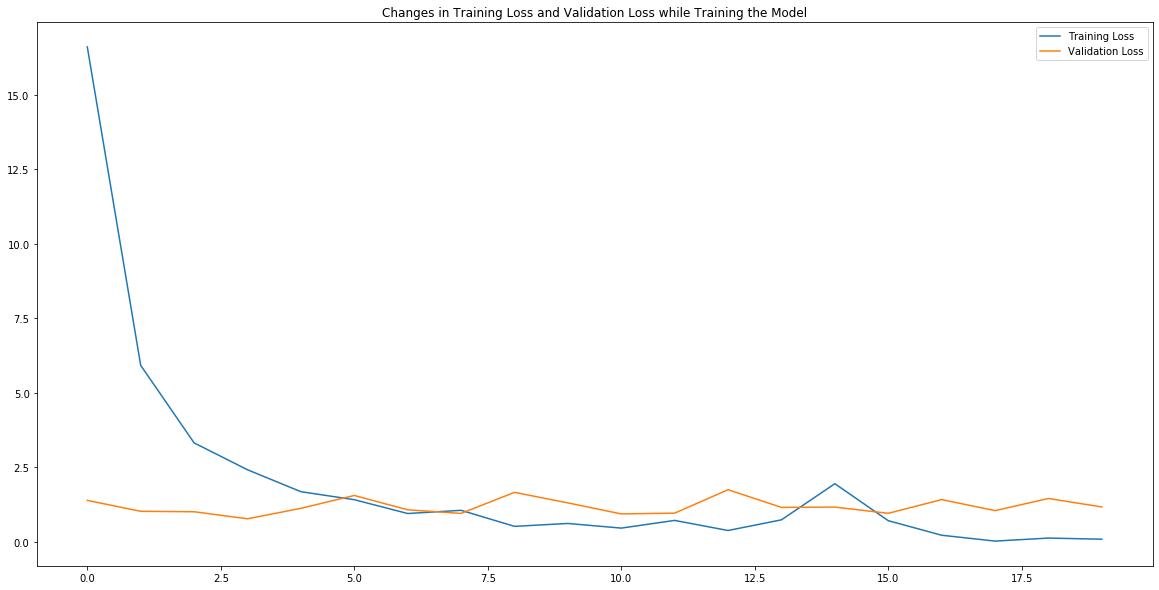

In [21]:
# Visualizing training and validation loss changes throughout the training process
plt.figure(figsize=(20,10))
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend()
plt.title("Changes in Training Loss and Validation Loss while Training the Model")
plt.show()

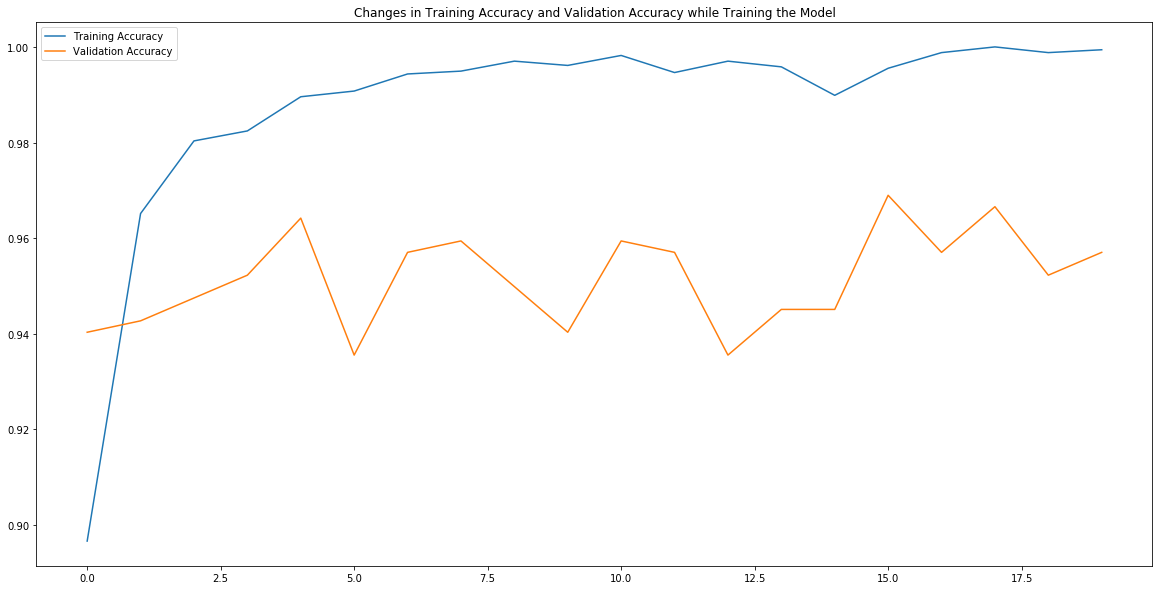

In [22]:
# Visualizing validation accuracy changes throughout the training process
plt.figure(figsize=(20,10))
plt.plot(range(epochs), train_acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Changes in Training Accuracy and Validation Accuracy while Training the Model")
plt.show()

In [23]:
best_epoch = 16 # deciding based on lowest validation loss and highest accuracy comparitively
def LoadModel(fpath):
    '''
    function to load the saved model
    '''
    c = torch.load(fpath)
    model = c['model']
    model.load_state_dict(c['state_dict'])
    # as we have to perform testing, we don't need backpropagation so setting 'requires_grad' as false
    for parameter in model.parameters():
        parameter.requires_grad = False
    # model.eval() ->  .eval() does not change any behaviour of gradient calculations , but are used to set specific layers
    #                  like dropout and batchnorm to evaluation mode i.e. dropout layer won't drop activations and 
    #                  batchnorm will use running estimates instead of batch statistics.
    return model.eval()
fpath = mdl + str(best_epoch) + ".pth"

In [24]:
loaded_model = LoadModel(fpath)
train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

In [30]:
# Testing accuracy of the model
correct_test = 0
total_test = 0    
with torch.no_grad():
    for x, y in test:
        x, y = x.cuda(), y.cuda()
        # forward pass
        result = loaded_model(x)
        # calculating accuracy
        _, maximum_test = torch.max(result.data,1)
        total_test += y.size(0)
        correct_test += (maximum_test==y).sum().item()
accuracy = correct_test/total_test
print("Accuracy of the model: " + str(round(accuracy*100)) + "%")

Accuracy of the model: 98%


##### To be tested in real-time.